In [1]:
# General purpose imports to handle paths, files etc
import os
import os.path as op
import glob
import pandas as pd
import numpy as np
import json
import requests
import urllib.request
from tqdm import tqdm
# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

import nibabel as nib

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from IPython.display import Image
from scipy.io import loadmat


# Useful functions to define and import datasets from open neuro
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm



def reset_overlays():
    """
    Clears view and completely remove visualization. All files opened in FSLeyes are closed.
    The view (along with any color map) is reset to the regular ortho panel.
    """
    l = frame.overlayList
    while(len(l)>0):
        del l[0]
    frame.removeViewPanel(frame.viewPanels[0])
    # Put back an ortho panel in our viz for future displays
    frame.addViewPanel(OrthoPanel)
    
def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')
        
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data

from nilearn import image
from nilearn.plotting import plot_prob_atlas
%matplotlib inline
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from nilearn.decomposition import CanICA

# MINI PROJECT 2
## Variant 3

##### Downloading the dataset

In [2]:
dataset_id = 'ds001145'
sub = 'sub-04' 
subject = '04'

# Download one subject's data from each dataset
sample_path = "dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

In [3]:
preproc_root

'/home/hajoub/Desktop/MyFiles/NSSP_proj2/dataset/ds001145/derivatives/preprocessed_data'

In [3]:
os.system("""openneuro-py download --dataset {} --include sub-{}/anat/sub-04_T1w.nii.gz
          --include sub-{}/func/sub-{}_task-watchmovie_bold.nii.gz 
          --include dataset_description.json 
          --target_dir {}""".format(dataset_id, subject, subject, subject, subject, subject, bids_root).replace("\n", " "))

0

In [4]:
bids_root

'/home/hajoub/Desktop/MyFiles/NSSP_proj2/dataset/ds001145'

In [5]:
print_dir_tree(bids_root, max_depth=4)

|ds001145/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-04/
|------------ anat/
|--- sub-04/
|------ anat/
|--------- sub-04_T1w.nii.gz
|------ func/
|--------- sub-04_task-watchmovie_bold.nii.gz


### Brain extraction

In [6]:
reset_overlays()
sub= 'sub-04'
load(op.join(bids_root, sub, 'anat', 'sub-04_T1w.nii.gz'))
name = 'sub-04_T1w.nii.gz'

In [7]:
anatomical_path = op.join(bids_root, sub, 'anat', 'sub-04_T1w.nii.gz')   
betted_brain_path = op.join(preproc_root, sub, 'anat', 'sub-04_T1w_ext')

bet(anatomical_path, betted_brain_path, mask=True, robust=True, fracintensity = 0.4)
    

{}

In [8]:
print_dir_tree(bids_root, max_depth=5)

|ds001145/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-04/
|------------ anat/
|--------------- sub-04_T1w_ext.nii.gz
|--------------- sub-04_T1w_ext_mask.nii.gz
|--- sub-04/
|------ anat/
|--------- sub-04_T1w.nii.gz
|------ func/
|--------- sub-04_task-watchmovie_bold.nii.gz


In [9]:
load(betted_brain_path + "_mask.nii.gz")

Image(sub-04_T1w_ext_mask, /home/hajoub/Desktop/MyFiles/NSSP_proj2/dataset/ds001145/derivatives/preprocessed_data/sub-04/anat/sub-04_T1w_ext_mask.nii.gz)

### 1. Briefly describe the dataset and the scientific question you want to answer.

In [ ]:
img = nib.load(op.join(bids_root, sub, 'func', 'sub-04_task-watchmovie_bold.nii.gz')   )
affine = img.affine
fdata = img.get_fdata()
x, y, z, N_vol = fdata.shape

In [ ]:
display(x, y, z, N_vol)
X_ = fdata.reshape(-1, fdata.shape[-1])
X = X_.T
display(X.shape)
mask_path = betted_brain_path + "_mask.nii.gz"
T1w_img = nib.load(anatomical_path)
mask = nob.load(mask_path)

icbms = datasets.fetch_icbm152_2009()
#masker = NiftiMasker(mask_img=icbms.mask)
mask_path = betted_brain_path + "_mask.nii.gz"
masker = NiftiMasker(mask_img= mask_path)
plot_stat_map(icbms.mask, black_bg=True, title='the brain mask', colorbar=False,)

61

73

61

1028

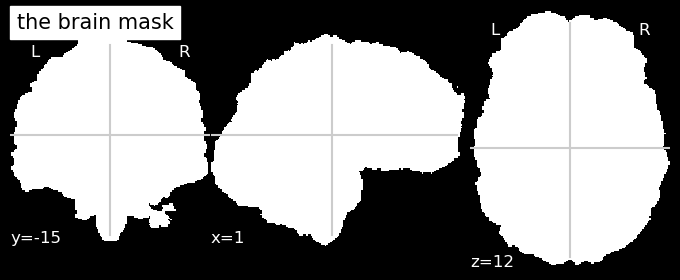

In [14]:
mask_path = betted_brain_path + "_mask.nii.gz"
masker = NiftiMasker(mask_img= mask_path)
plot_stat_map(mask_path, black_bg=True, title='the brain mask', colorbar=False,bg_img= None)

In [ ]:
mask_path

In [15]:
#* Run FastICA on X -- check 

S_dict = {}

# assign the variable nb_components to be the list of components (try 3-5 values )

nb_components =  [4,]#10]#20, 60 ...]

## NOTE that 60 components can be computational costly

#* We will transpose the matrix X so that ICA algorithm operates on the voxels dimension.
#* In other words, the estimated sources (S) should be have dimensionality [#voxels]


for n in nb_components:
    print(f"Processing component {n}")
    # run PCA as a preprocessing step for ICA with twice the number of components
    n2=2*n
    
    pca = PCA(n_components=n2)
    H = pca.fit_transform(X.T)  # Reconstruct signals based on orthogonal components
    
    # Reminder: Fast ICA model S = X W
    print("Running FastICA with n = %d components" %n)
    ### BEGIN SOLUTION
    ica = FastICA(n_components=n, random_state=1, max_iter=200)
    S_ = ica.fit_transform(H)  # Get the estimated sources (S)
    print(S_.shape)
    W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
    S_dict[n] = S_ # store the results in a dictionary

    print("Done")

Processing component 4


NameError: name 'X' is not defined

### 2. List the basic steps of the multivariate method you chose and explicit the maths behind it.

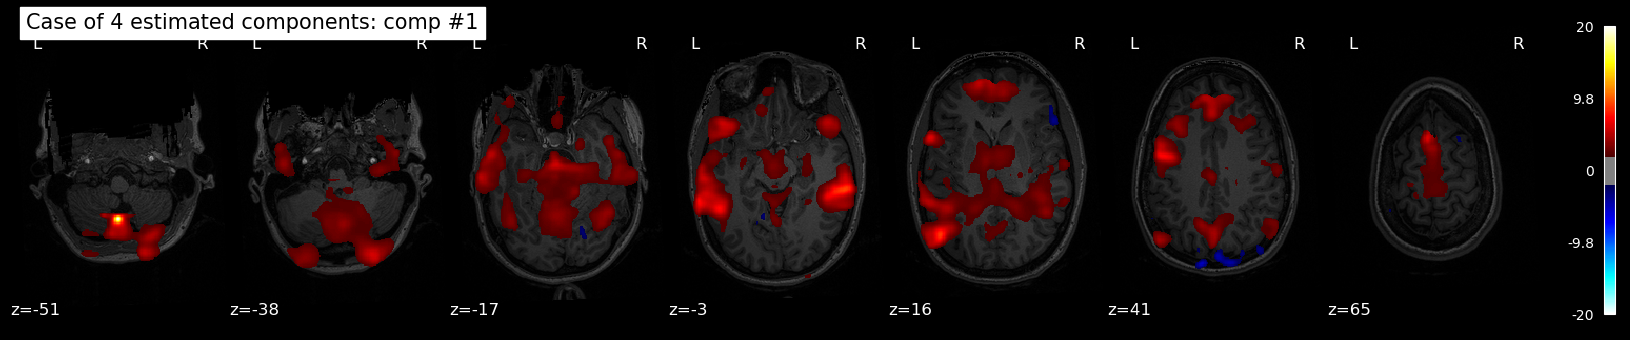

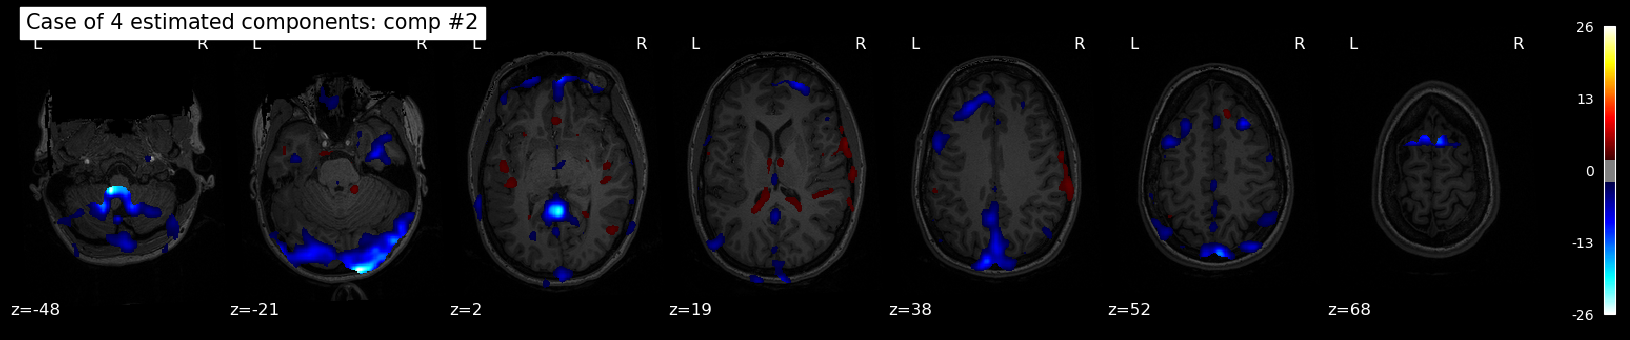

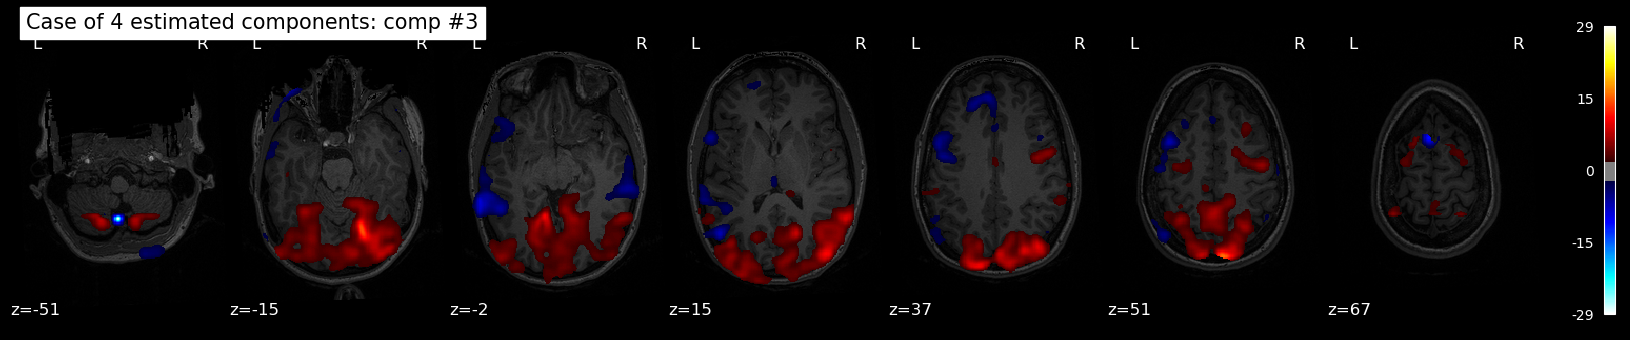

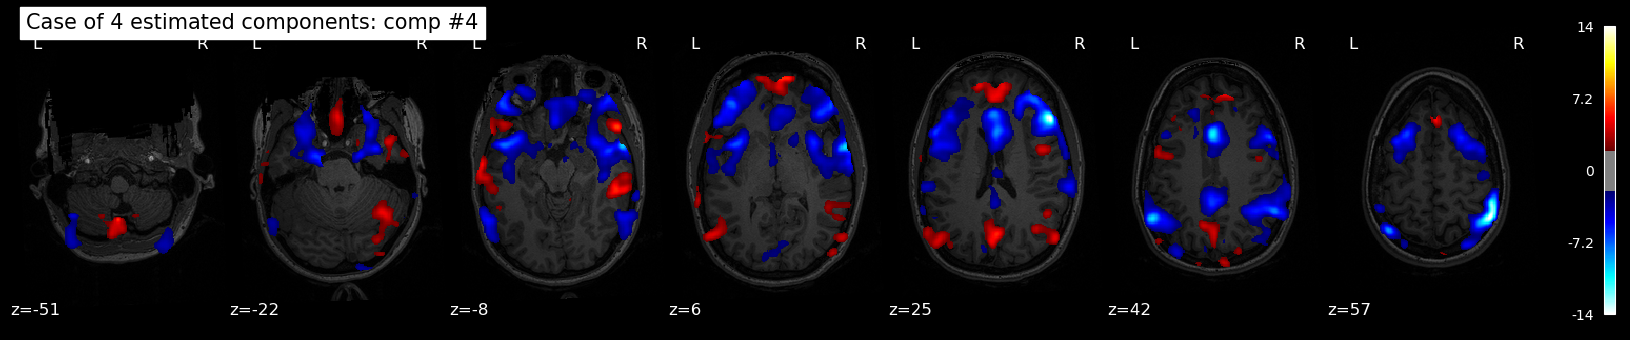

In [15]:
for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components , change 10 with 4 to plot less
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        data = masker.fit_transform(s_img)
        masked_ = masker.inverse_transform(data) #mask the components
        plot_stat_map(masked_, display_mode="z", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=T1w_img,)
                      #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
        plt.show()

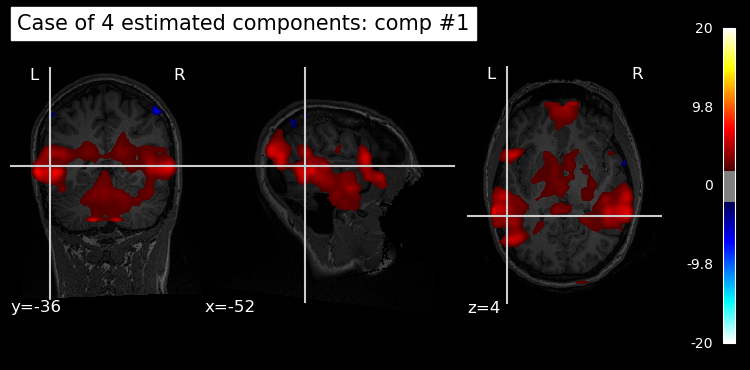

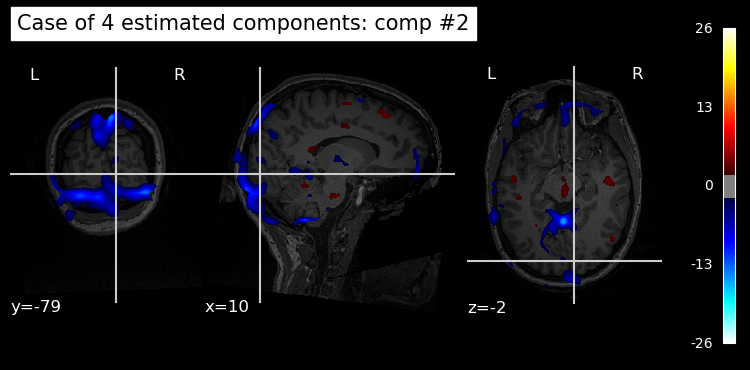

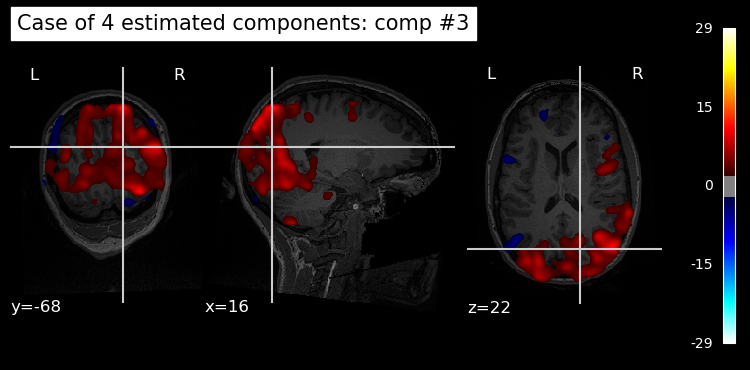

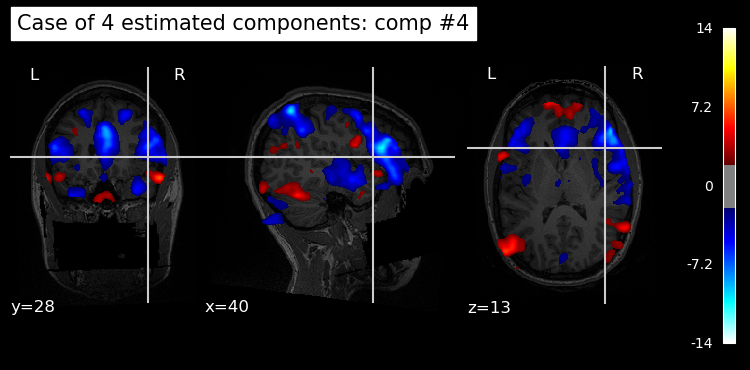

In [16]:
### BEGIN SOLUTION
#* Plot the group-level independent components for the different number of requested components.
for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        data = masker.fit_transform(s_img)
        masked_ = masker.inverse_transform(data) # mask the components
        plot_stat_map(masked_, display_mode="ortho", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=T1w_img,)
                      #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
        plt.show()

### END SOLUTION

### 3. Vary the number of components you are considering and visualise the spatial maps. Check if you are able to find meaningful maps according to the question you asked or the type of the dataset. You can also look at the atlas to have hints on the brain regions of interest.

In [27]:
#Make function for everything 

def spatial_ICA(ica_comp,  pca = True, axial_plots = True, other_plots = False)

(271633,)

## GLM Across Groups 

In [2]:
# General purpose imports to handle paths, files etc
import os
import os.path as op
import glob
import pandas as pd
import numpy as np
import json
import requests
import urllib.request
from tqdm import tqdm
# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

import nibabel as nib

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from IPython.display import Image
from scipy.io import loadmat


# Useful functions to define and import datasets from open neuro
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm



def reset_overlays():
    """
    Clears view and completely remove visualization. All files opened in FSLeyes are closed.
    The view (along with any color map) is reset to the regular ortho panel.
    """
    l = frame.overlayList
    while(len(l)>0):
        del l[0]
    frame.removeViewPanel(frame.viewPanels[0])
    # Put back an ortho panel in our viz for future displays
    frame.addViewPanel(OrthoPanel)
    
def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')
        
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data

from nilearn import image
from nilearn.plotting import plot_prob_atlas
%matplotlib inline
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from nilearn.decomposition import CanICA

### Downolading all subjects

In [6]:
#Downloading the 10 first subjects.
max_sub_num = 3
sub_nums  = [i for i in range(1,max_sub_num + 1)]
sub_nums

[1, 2, 3]

In [8]:
dataset_id = 'ds001145'


# Download one subject's data from each dataset
sample_path = "dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

In [10]:
''''
for sub_num in sub_nums :
    sub = f'sub-0{sub_num}' 
    subject = f'0{sub_num}'
    os.system("""openneuro-py download --dataset {} --include sub-{}/anat/*
          --include sub-{}/func/sub-{}_task-watchmovie_bold.nii.gz 
          --include dataset_description.json 
          --target_dir {}""".format(dataset_id, subject, subject, subject, subject, subject, bids_root).replace("\n", " "))

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-10-5f86fd8dc9c6>, line 8)

In [9]:
print_dir_tree(bids_root, max_depth=4)

In [17]:
def performing_glm (events, fmri_img, rep_time, frame_times) : 

    fmri_glm = FirstLevelModel(t_r=rep_time,
                               noise_model='ar1',
                               standardize=False,
                               hrf_model='spm',
                               drift_model=None,
                               high_pass=.01)
    design_matrices = make_first_level_design_matrix(frame_times, events,
                          drift_model='polynomial', drift_order=3)

    
    # Fit the model to our design and data
    return fmri_glm.fit(subject_data, design_matrices=design_matrices)

In [11]:
watch =  [0]*8 + [1]*990
duration =[1.5]*998
onset = np.arange(3, 1500, 1.5)
events = {'trial_type':watch, 'duration' :duration, 'onset': onset}
events_df = pd.DataFrame(events)
rep_time = 1.5

In [13]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
import numpy as np
import pandas as pd

glm_fits = []
for sub_num in sub_nums:
    subject = f'0{sub_num}'
    f_data_path = op.join(bids_root,f'sub-0{sub_num}','func',f'sub-0{sub_num}_task-watchmovie_bold.nii.gz')
    subject_data = nib.load(f_data_path)
    subject_data = subject_data.slicer[..., :998]
    fmri_glm = performing_glm(events_df, subject_data, rep_time, onset)
    glm_fits.append(fmri_glm)

In [14]:
len(glm_fits)

3

Here we don't need to concatenate the data since it's already 4D data.

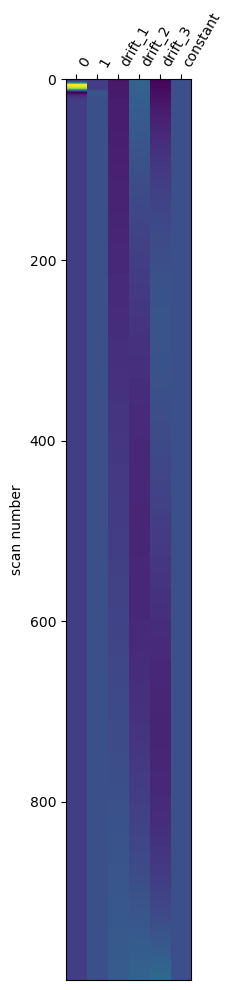

In [45]:
from nilearn.plotting import plot_design_matrix

plot_design_matrix(glm_fits[2].design_matrices_[0])
plt.show()

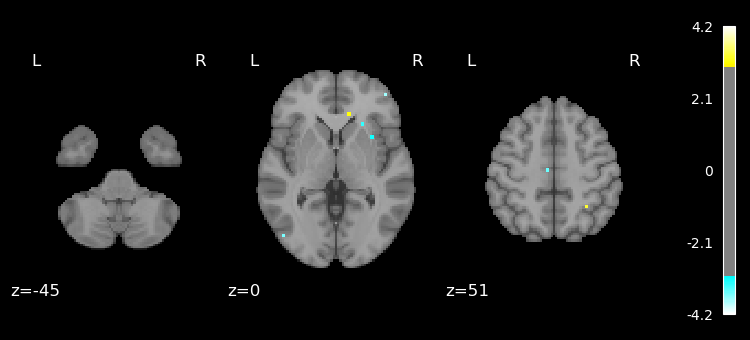

In [18]:
from nilearn import plotting

# Define the contrast vector for the difference between watching and not watching
contrast_vector = [[1,-1,0,0,0,0]]#,[1,-1,0,0,0,0],[1,-1,0,0,0,0]]

# Compute the contrast
z_map = fmri_glm.compute_contrast(contrast_vector, stat_type='F', output_type='z_score')

# Plot the contrast map
plotting.plot_stat_map(z_map, threshold=3.1, display_mode='z', cut_coords=3, black_bg=True)

# Show the plot
plotting.show()

In [22]:
from nilearn import plotting

# Define the contrast vector for the difference between watching and not watching
contrast_vector = [[1,-1,0,0,0,0],[1,-1,0,0,0,0],[1,-1,0,0,0,0]]

# Compute the contrast
z_map = fmri_glm.compute_contrast(contrast_vector, stat_type='F', output_type='z_score')

# Plot the contrast map
plotting.plot_stat_map(z_map, threshold=3.1, display_mode='z', cut_coords=3, black_bg=True)

# Show the plot
plotting.show()

ValueError: 3 contrasts given, while there are 1 runs.

#### Now let's assess the consistency of our results across subjects

In [19]:
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map

# Let's assume contrast_maps is a list of file paths to the contrast maps of each subject
contrast_maps = ['sub01_contrast.nii.gz', 'sub02_contrast.nii.gz', ...]

# Instantiate the second-level model
second_level_model = SecondLevelModel(smoothing_fwhm=8.0)

# Fit the model to the contrast maps
second_level_model = second_level_model.fit(contrast_maps)

# Define the one-sample t-test contrast: [1] means we test the mean against 0
second_level_contrast = [1]

# Compute the contrast of the one-sample t-test
z_map = second_level_model.compute_contrast(second_level_contrast,
                                            output_type='z_score')

# Plot the second-level contrast map
plot_stat_map(z_map, threshold=3.1, display_mode='z', cut_coords=3, black_bg=True)

# Save the second-level contrast map
z_map.to_filename('group_level_z_map.nii.gz')


TypeError: Elements of second_level_input must be of the same type. Got object type <class 'ellipsis'> at idx 2.